In [1]:
import numpy as np
import torch 
import torch.nn as nn

In [2]:
sequence_length = 4
batch_size = 1
input_dim = 512
d_model = 512 # Output of the attention unit for each word
x = torch.randn((batch_size, sequence_length, input_dim))

In [4]:
x.shape

torch.Size([1, 4, 512])

In [5]:
x

tensor([[[-0.5411,  1.4443, -0.2205,  ..., -0.7539,  0.0490, -0.7641],
         [-2.4689,  0.3991,  0.5916,  ..., -0.3884,  1.4607, -1.1697],
         [ 0.0944,  0.7401, -1.2576,  ...,  1.0603,  0.2804, -0.8461],
         [-0.2098, -0.0342,  0.3869,  ..., -0.1220, -0.0032,  0.3784]]])

In [6]:
qkv_layer = nn.Linear(in_features=input_dim, out_features= 3 * d_model)

In [7]:
qkv = qkv_layer(x)

In [8]:
qkv.shape

torch.Size([1, 4, 1536])

In [9]:
qkv

tensor([[[-1.5774, -0.5057, -0.5104,  ...,  0.4245,  0.4693,  0.6770],
         [ 0.6629,  0.7068, -1.2993,  ...,  0.1124, -0.4004,  0.2675],
         [-0.3748,  0.0986, -0.2376,  ..., -0.0325,  0.8518,  0.4317],
         [ 0.1956, -0.6455, -0.0261,  ..., -0.0580, -1.0893, -0.9188]]],
       grad_fn=<ViewBackward0>)

Text(0.5, 1.0, 'qkv distribution')

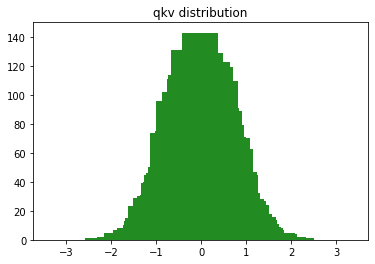

In [10]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1,1,0.01)*3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title("qkv distribution")

In [11]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3* head_dim)

In [12]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [14]:
qkv = qkv.permute(0,2,1,3) # [batch_size, num_heads, sequence_length, 3*head_dim]
qkv.shape

torch.Size([1, 8, 4, 192])

In [16]:
q,k,v = qkv.chunk(3, dim=-1) # dim = -1 since we are breaking down the last dim into 3 parts
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

### Self Attention for multiple heads

For a single head: 
![self-attention-formula.png](self-attention-formula.png)

In [18]:
import math
d_k = q.shape[-1]
scaled = torch.matmul(q,k.transpose(-2,-1)) / math.sqrt(d_k) # (-2,-1) since we wanted to transpose the last 2 dimensions
scaled.shape

torch.Size([1, 8, 4, 4])

In [20]:
k.transpose(-2,-1).shape

torch.Size([1, 8, 64, 4])

In [27]:
mask = torch.full(scaled.shape, float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][1] # mask for input to a single head

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [22]:
(scaled + mask)[0][0]

tensor([[-4.7485e-01,        -inf,        -inf,        -inf],
        [ 3.4870e-01, -5.1519e-01,        -inf,        -inf],
        [ 1.3648e-01,  2.3076e-01,  5.1203e-01,        -inf],
        [ 3.9127e-01, -2.1889e-04, -3.2815e-01,  1.9039e-01]],
       grad_fn=<SelectBackward0>)